### Skunkworks Data Science Team 3 Final Submission

In [20]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics
from collections import Counter
from sklearn.cluster import AffinityPropagation

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#### Survival Predictive Model

In [2]:
# import data
titanic = pd.read_csv('../data/titanic.csv')

In [3]:
# Drop body and cabin since more than 50% of the data is missing
titanic.drop(['cabin', 'body'], axis = 1, inplace = True)

In [4]:
# Drop boat, home.dest and use complete case analysis to drop rows with missing data
titanic.drop(['boat', 'home.dest'], axis = 1, inplace = True)
titanic.dropna(inplace = True)

In [5]:
# Create a new column FamilyCount which is the sum of SibSp and Parch
titanic["family_count"] = titanic['sibsp'] + titanic['parch']

In [6]:
# Create a title column using RegEx from the name
title  =  titanic['name'].str.extract(r', ([^\.]+)\.')
titanic['title'] = title

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


In [7]:
# Take the log of fare to make it more normally distributed 
titanic['fare'] = titanic['fare'].map(lambda x: np.log1p(x))

In [8]:
# One hot encode categorical values
titanic = pd.get_dummies(titanic, columns = ['embarked', 'sex', 'title'], drop_first = True)

In [9]:
# Define features and target in train data
X = titanic.drop(['name', 'ticket', 'survived'], axis = 1)
y = titanic['survived']

In [10]:
# Standardize the predictors in X
ss = StandardScaler()
ss.fit(X) 
X_scaled = ss.transform(X)

In [11]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y , test_size = 0.3)

In [12]:
# Gridsearch on logistic regression model 
lr_params = {'penalty':['l1', 'l2'], 
             'C': np.logspace(-5, 2, 10)}
gs = GridSearchCV(LogisticRegression(), param_grid = lr_params)
gs.fit(X_train, y_train)

# Results 
gs.best_score_, gs.best_params_

(0.8027397260273973, {'C': 0.4641588833612782, 'penalty': 'l2'})

In [13]:
# Gridsearch test accuracy score
gs.score(X_test, y_test)

0.8274760383386581

In [14]:
# Evaluate gridsearched model with AUC-ROC score
y_score = gs.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_score)

0.8599667082813149

In [15]:
# Determine top predictors in model 
coefs = pd.DataFrame(gs.best_estimator_.coef_[0], index = X.columns, columns = ['coef'])
coefs.sort_values(by='coef', ascending = False, inplace=True)
coefs.head()

,coef
title_Mrs,0.441119
title_Master,0.336003
title_Miss,0.247934
title_Sir,0.141039
title_Ms,0.128058


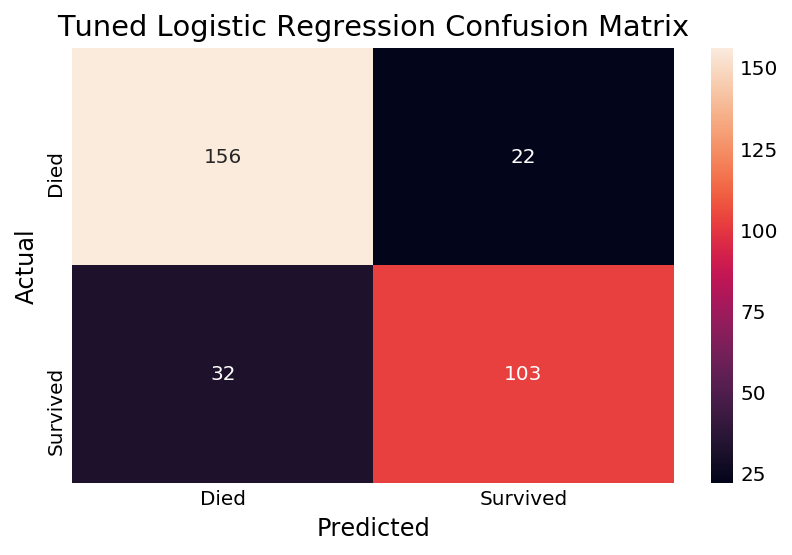

In [16]:
# Create a heatmap confusion matrix - get predictions 
predictions = gs.predict(X_test)

# Create confusion matrix 
classes = ["Died", 'Survived']
cm = metrics.confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, columns=classes)
cm.index = classes

# Plot matrix on heatmap 
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Tuned Logistic Regression Confusion Matrix');

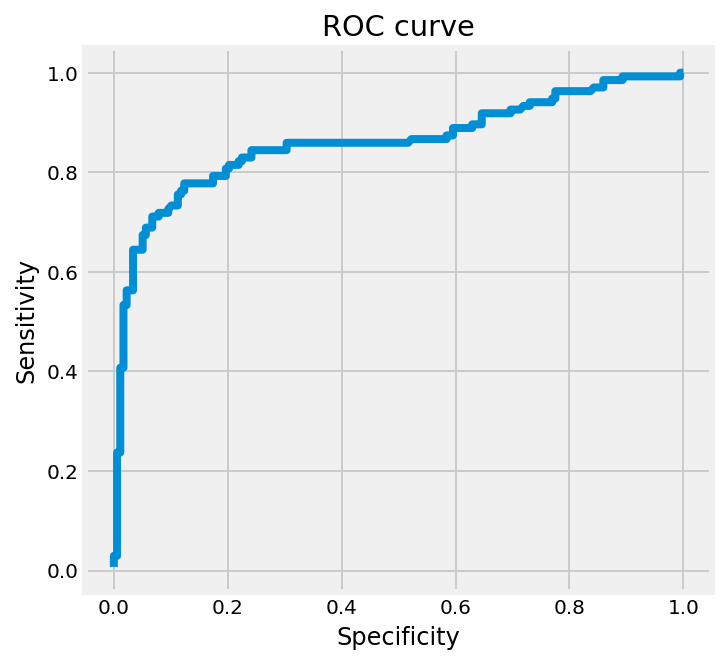

In [17]:
# ROC Plot 
y_probs = gs.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_probs)

fig = plt.figure(figsize = (5,5))
plt.plot(fpr, tpr)

# Labels
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve');

#### Clustering Analysis 

In [3]:
# import data
titanic = pd.read_csv('../data/titanic.csv')

# Create family count column 
titanic["family_count"] = titanic['sibsp'] + titanic['parch']

# extract titles from names 
title  =  titanic['name'].str.extract(r', ([^\.]+)\.')
titanic['title'] = title

# normalize fare
titanic['fare'] = titanic['fare'].map(lambda x: np.log1p(x))

# drop features 
titanic.drop(['boat', 'home.dest', 'body', 'name', 'ticket', 'cabin'], axis = 1, inplace = True)
titanic.dropna(inplace = True)

# one hot encode categories 
titanic = pd.get_dummies(titanic, columns = ['embarked', 'sex', 'title'], drop_first = True)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [5]:
# Standardize the predictors 
df = titanic.copy()
ss = StandardScaler()
ss.fit(df) 
df = ss.transform(df)

In [21]:
# Perform Affinity Propagation clustering
af = AffinityPropagation(damping = .99 , preference =  -50)
cluster = af.fit(df)
cluster_centers = cluster.cluster_centers_

In [22]:
# 8 clusters with 27 feature values  
cluster_centers.shape

(8, 27)

In [23]:
# Convert cluster output to dataframe and reassign feature names 
clusters = pd.DataFrame(cluster_centers)
cols = dict(zip(range(27), titanic.columns))
clusters.rename(mapper = cols,axis = 1, inplace = True)
clusters.index.rename('Group Number', inplace = True)
clusters

,pclass,survived,age,sibsp,parch,fare,family_count,embarked_Q,embarked_S,sex_male,...,title_Master,title_Miss,title_Mlle,title_Mme,title_Mr,title_Mrs,title_Ms,title_Rev,title_Sir,title_the Countess
Group Number,,,,,,,,,,,,,,,,,,,,,
0,-1.438817,1.205868,0.779059,-0.552587,-0.502064,1.902145,-0.637231,-0.224394,-1.726533,-1.304635,...,-0.231377,1.997606,-0.043832,-0.030979,-1.119241,-0.439732,-0.030979,-0.087917,-0.030979,-0.030979
1,-1.438817,1.205868,1.266546,0.543133,0.688056,1.359371,0.738818,-0.224394,-1.726533,-1.304635,...,-0.231377,-0.500599,-0.043832,-0.030979,-1.119241,2.274115,-0.030979,-0.087917,-0.030979,-0.030979
2,-1.438817,1.205868,0.361214,0.543133,-0.502064,1.413118,0.050794,-0.224394,0.579195,-1.304635,...,-0.231377,-0.500599,-0.043832,-0.030979,-1.119241,2.274115,-0.030979,-0.087917,-0.030979,-0.030979
3,-1.438817,1.205868,-0.961964,-0.552587,0.688056,1.041293,0.050794,-0.224394,-1.726533,-1.304635,...,-0.231377,1.997606,-0.043832,-0.030979,-1.119241,-0.439732,-0.030979,-0.087917,-0.030979,-0.030979
4,-0.248741,-0.829278,0.361214,-0.552587,-0.502064,0.232643,-0.637231,-0.224394,0.579195,0.766498,...,-0.231377,-0.500599,-0.043832,-0.030979,0.893463,-0.439732,-0.030979,-0.087917,-0.030979,-0.030979
5,-0.248741,-0.829278,0.152291,1.638853,-0.502064,1.283071,0.738818,-0.224394,0.579195,0.766498,...,-0.231377,-0.500599,-0.043832,-0.030979,0.893463,-0.439732,-0.030979,-0.087917,-0.030979,-0.030979
6,0.941336,-0.829278,-0.474478,0.543133,-0.502064,-0.382605,0.050794,-0.224394,0.579195,0.766498,...,-0.231377,-0.500599,-0.043832,-0.030979,0.893463,-0.439732,-0.030979,-0.087917,-0.030979,-0.030979
7,0.941336,-0.829278,0.918341,-0.552587,-0.502064,-1.099973,-0.637231,-0.224394,0.579195,0.766498,...,-0.231377,-0.500599,-0.043832,-0.030979,0.893463,-0.439732,-0.030979,-0.087917,-0.030979,-0.030979


In [24]:
# Define plotting function 
def plot_group(group_num):
    fig = plt.figure(figsize = (10,5))
    sns.barplot(x = clusters.iloc[group_num:(group_num+1)].values[0], y = clusters.columns)
    plt.title('Group {} Profile'.format(group_num));

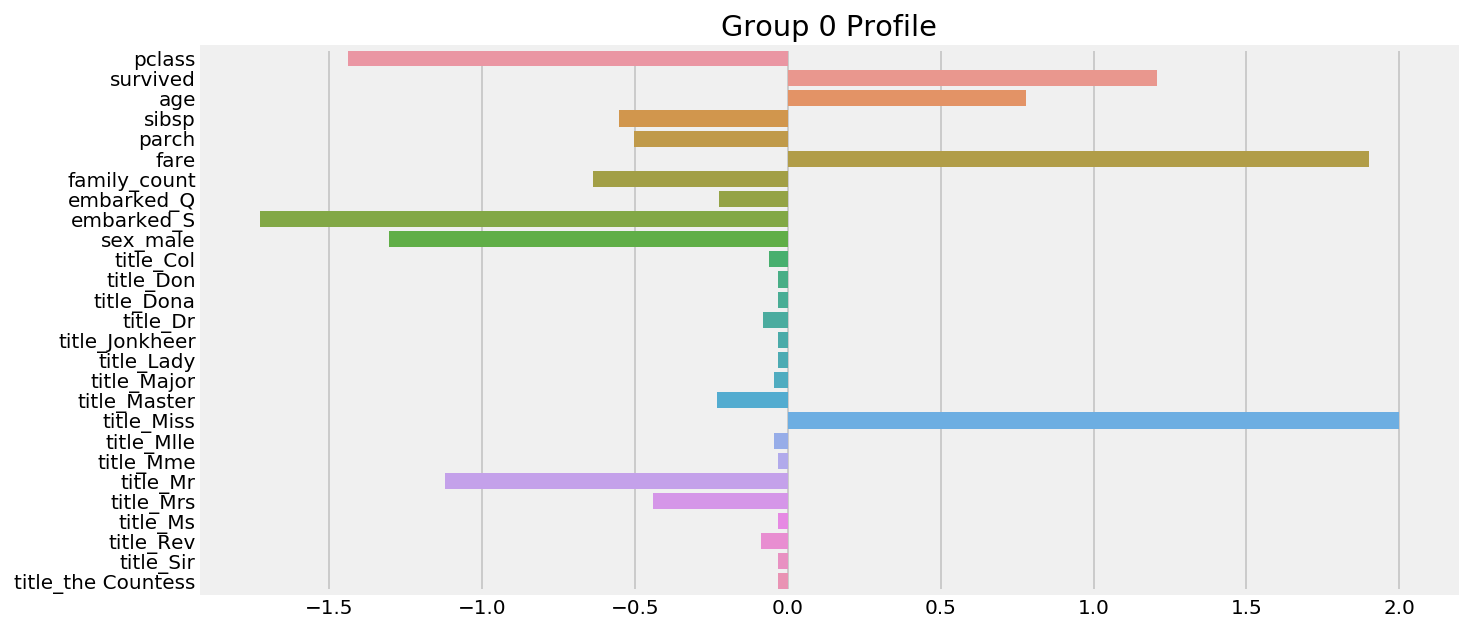

In [25]:
# Group 0 profile 
plot_group(0)

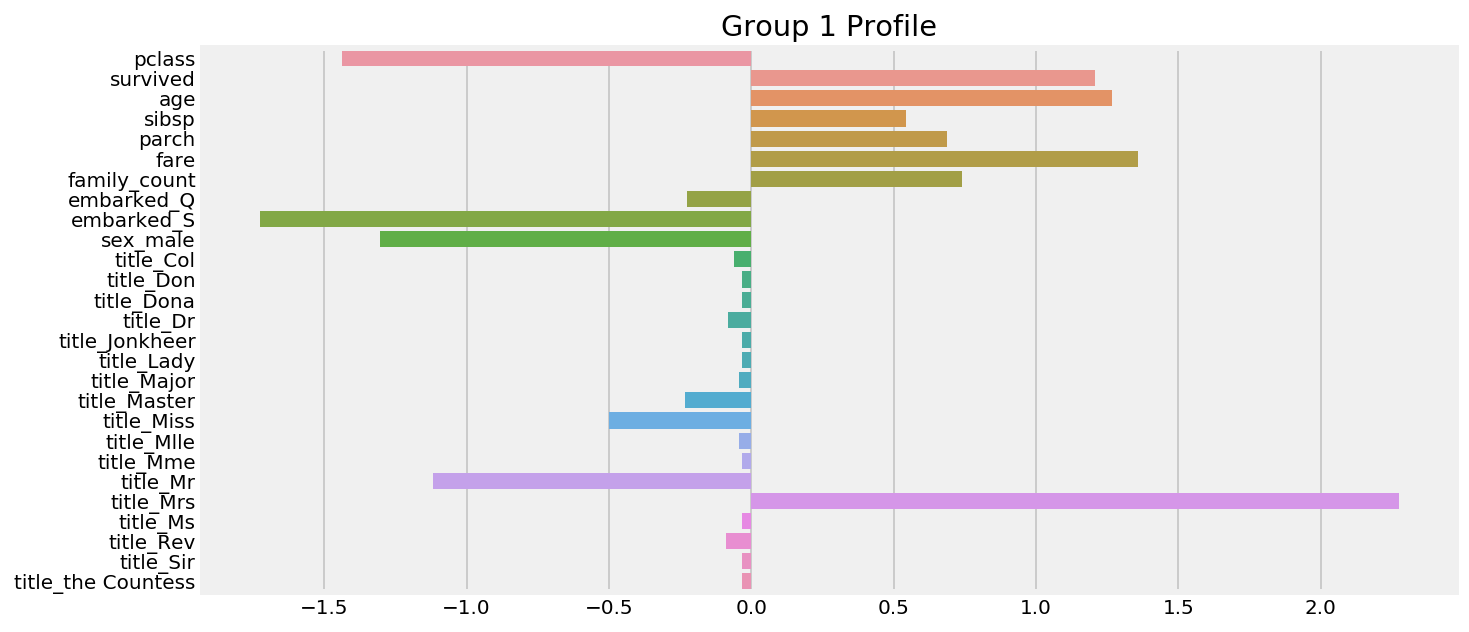

In [26]:
# Group 1 profile 
plot_group(1)

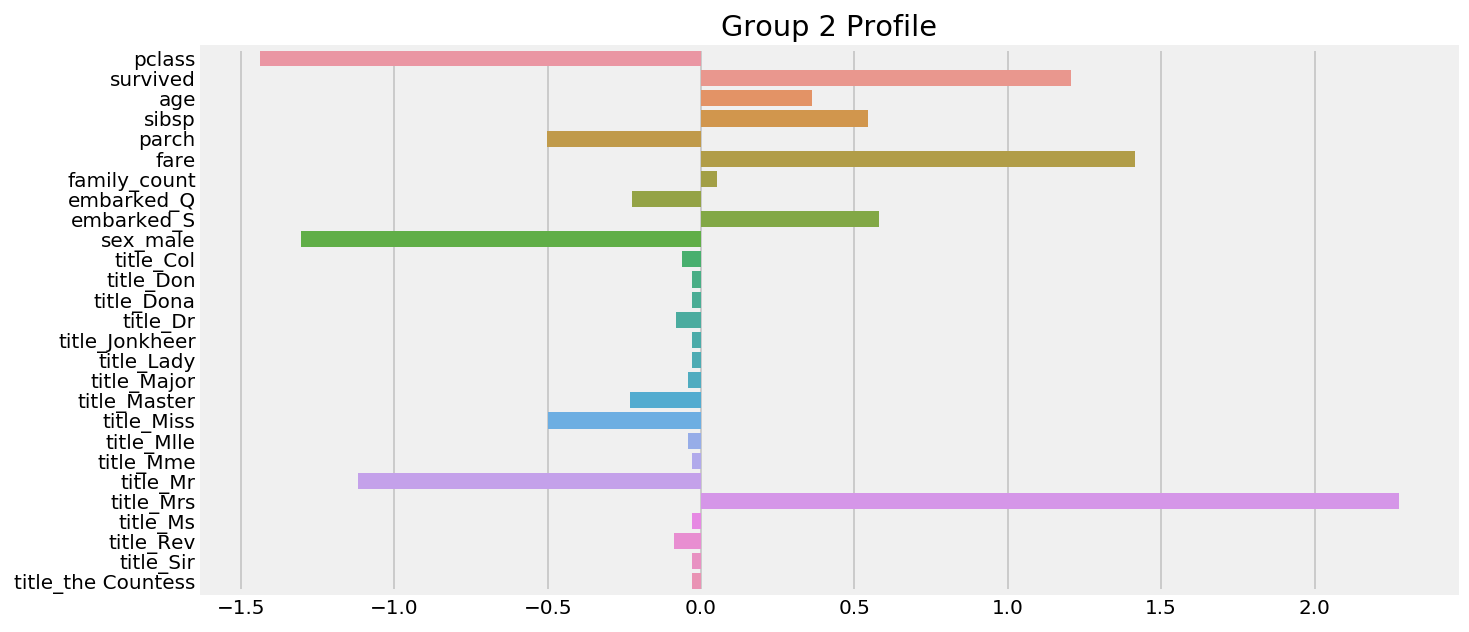

In [27]:
# Group 2 profile 
plot_group(2)

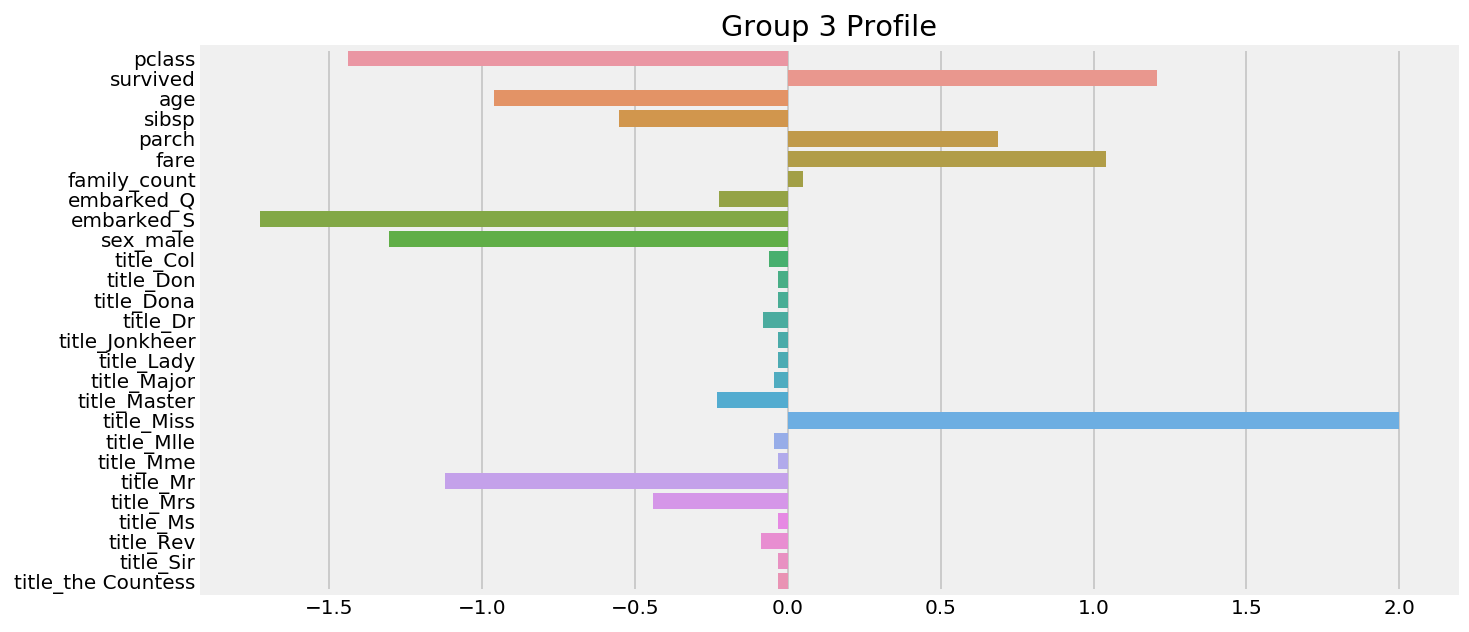

In [28]:
# Group 3 profile 
plot_group(3)

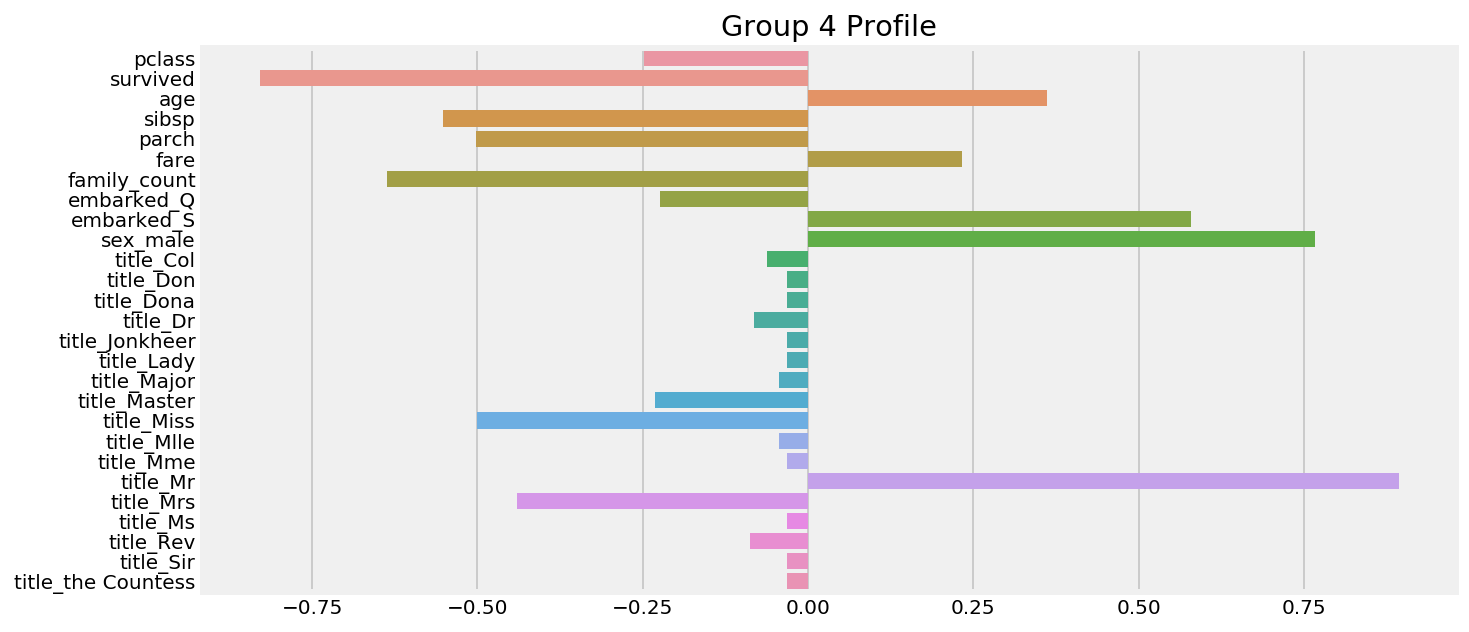

In [29]:
# Group 4 profile 
plot_group(4)

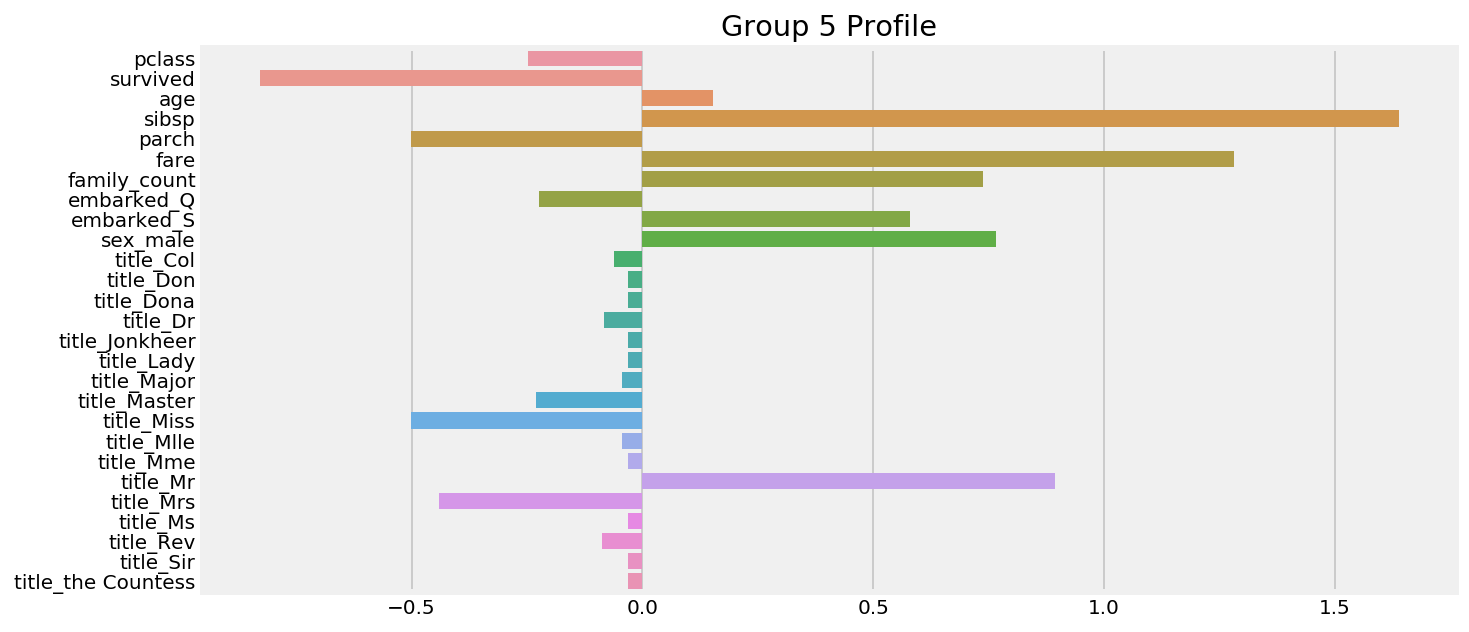

In [30]:
# Group 5 profile 
plot_group(5)

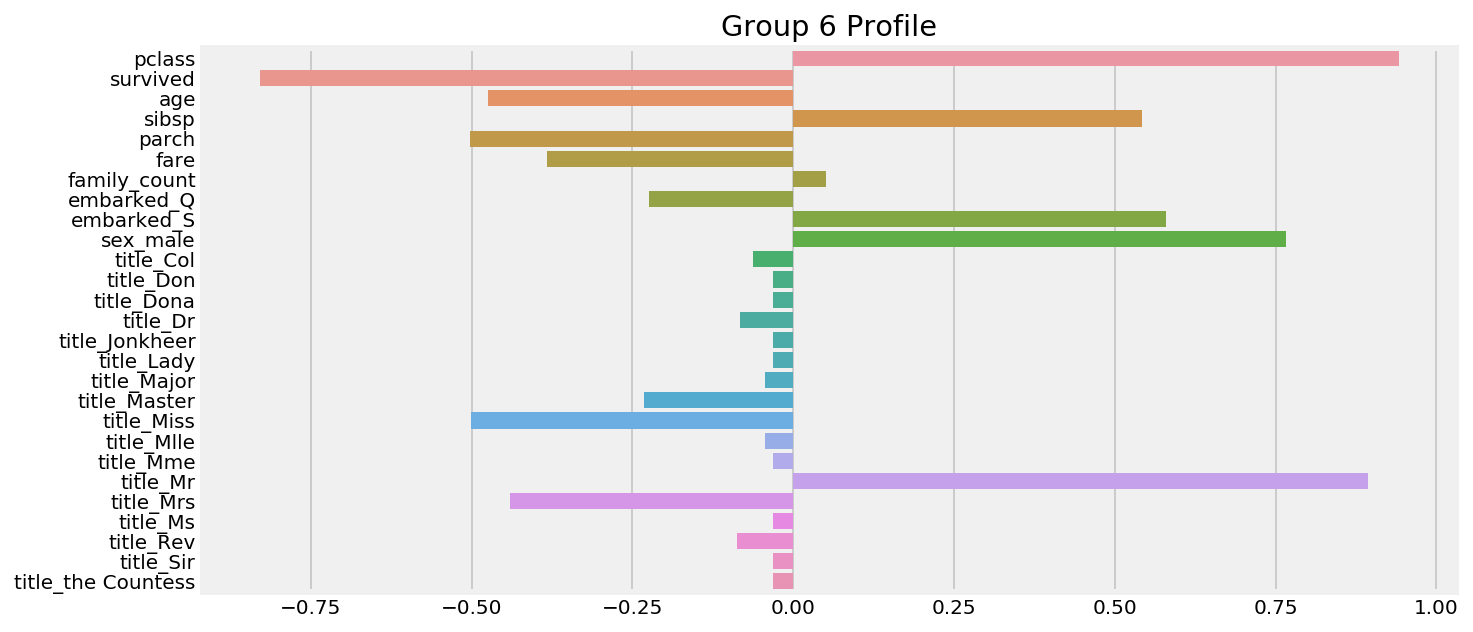

In [31]:
# Group 6 profile 
plot_group(6)

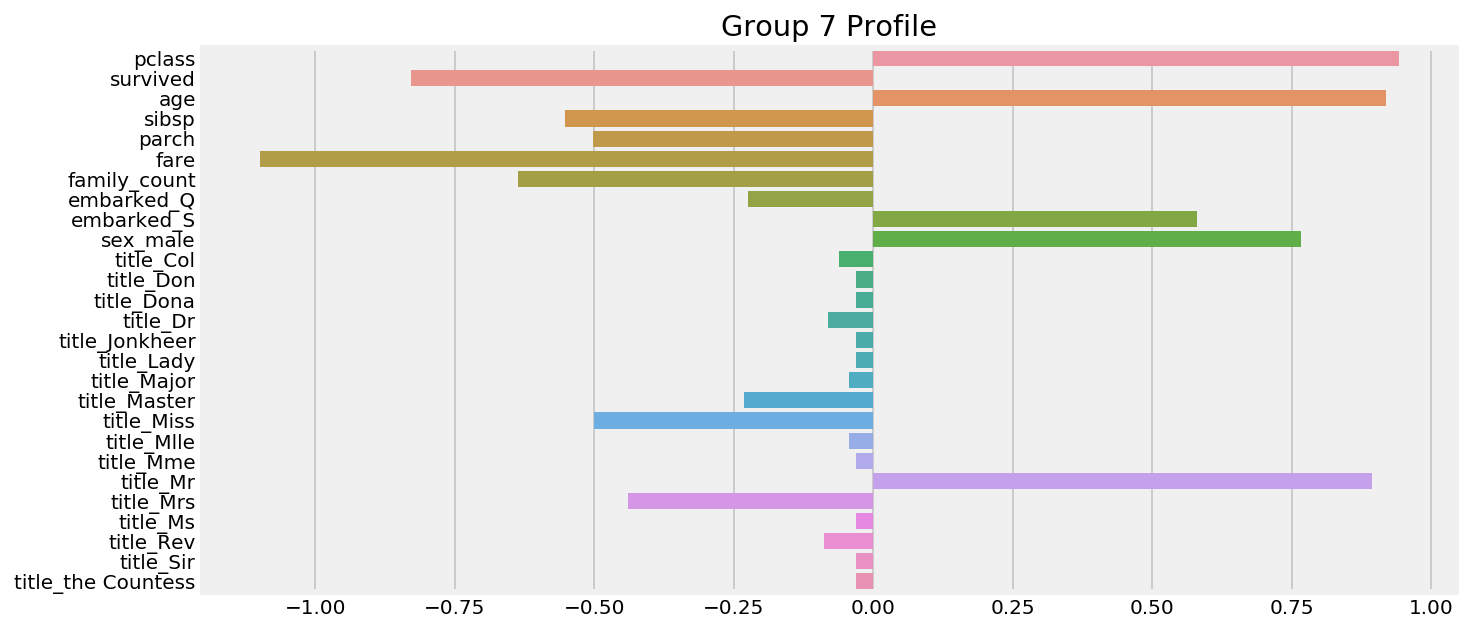

In [32]:
# Group 7 profile 
plot_group(7)